# 「建物構造」を本格的に特徴量抽出をする！

In [174]:
import pandas as pd
import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer
import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [175]:
train_df = pd.read_csv("../data/outer_data/train.csv")
train_df = train_df.drop('賃料', axis=1)
test_df = pd.read_csv('../data/outer_data/test.csv')
df = pd.concat([train_df, test_df], axis=0)

In [176]:
len(df)

62732

### テキスト整形用関数

In [177]:
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[『』]', ' ', replaced_text)   # 『』の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = re.sub(r' ', '', replaced_text)  # 空白の除去
    return replaced_text


def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_html_and_js_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    [x.extract() for x in soup.findAll(['script', 'style'])]
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def text_cleaning(text):
    text = clean_text(text)
    text = clean_html_tags(text)
    text = clean_html_and_js_tags(text)
    text = clean_url(text)
    text = normalize(text)
    text = lower_text(text)
    text = normalize_unicode(text)

    return text

「建物構造」特徴量を抽出

In [178]:
merge_building = df['建物構造']
merge_building = pd.DataFrame(merge_building)
merge_building.columns = ['カテゴリ建物構造']

In [179]:
merge_building

,カテゴリ建物構造
0,RC（鉄筋コンクリート）
1,鉄骨造
2,RC（鉄筋コンクリート）
3,RC（鉄筋コンクリート）
4,木造
...,...
31257,RC（鉄筋コンクリート）
31258,RC（鉄筋コンクリート）
31259,RC（鉄筋コンクリート）
31260,SRC（鉄骨鉄筋コンクリート）


In [180]:
for i in range(len(merge_building)):
    try:
        merge_building.loc[i] = clean_text(merge_building.loc[i])
        merge_building.loc[i] = merge_building.loc[i].replace('／', '')
        merge_building.loc[i] = merge_building.loc[i].replace('\t', ' ')
        merge_building.loc[i] = merge_building.loc[i].replace('rc鉄筋コンクリート', 'RC（鉄筋コンクリート）')
        merge_building.loc[i] = merge_building.loc[i].replace('src鉄骨鉄筋コンクリート', 'SRC（鉄骨鉄筋コンクリート）')
        merge_building.loc[i] = merge_building.loc[i].replace('alc軽量気泡コンクリート', 'ALC（軽量気泡コンクリート）')
        merge_building.loc[i] = merge_building.loc[i].replace('pcプレキャスト・コンクリート鉄筋コンクリート', 'PC（プレキャスト・コンクリート（鉄筋コンクリート））')
    except:
        pass

In [181]:
merge_building

,カテゴリ建物構造
0,RC（鉄筋コンクリート）
1,鉄骨造
2,RC（鉄筋コンクリート）
3,RC（鉄筋コンクリート）
4,木造
...,...
31257,RC（鉄筋コンクリート）
31258,RC（鉄筋コンクリート）
31259,RC（鉄筋コンクリート）
31260,SRC（鉄骨鉄筋コンクリート）


In [182]:
import category_encoders as ce

list_cols = ['カテゴリ建物構造']
addresses_encoder = ce.OrdinalEncoder(cols=list_cols, drop_invariant=True)
merge_building_c = addresses_encoder.fit_transform(merge_building)

In [183]:
merge_building.value_counts()

カテゴリ建物構造                   
RC（鉄筋コンクリート）                   34810
木造                             11062
鉄骨造                             7495
SRC（鉄骨鉄筋コンクリート）                 4792
軽量鉄骨                            3608
ALC（軽量気泡コンクリート）                  577
その他                              268
PC（プレキャスト・コンクリート（鉄筋コンクリート））      102
HPC（プレキャスト・コンクリート（重量鉄骨））          10
ブロック                               5
鉄筋ブロック                             3
dtype: int64

In [184]:
merge_building_c.value_counts()

カテゴリ建物構造
1           34810
3           11062
2            7495
4            4792
5            3608
6             577
7             268
8             102
9              10
10              5
11              3
dtype: int64

In [185]:
#訓練データとテストデータに再分割
building = merge_building_c[:len(train_df)]
building.to_csv('../data/handmade_data/building.csv',index=False)
test_building = merge_building_c[len(train_df):]
test_building.to_csv('../data/test_data/test_building.csv',index=False)

### 新しくした「建物構造」特徴量をLightGBMに突っ込む！

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
building = pd.read_csv('../data/handmade_data/building.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], 
                    building, buildings,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    kitchen_points, equipments, bath_toilet_points, broadcasts, parkings], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_building, test_buildings,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                     test_kitchen_points, test_equipments, test_bath_toilet_points, test_broadcasts, test_parkings], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','カテゴリ建物構造','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    'ガスコンロ', 'コンロ2口', 'システムキッチン', '給湯', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',
                    'エアコン付','シューズボックス','バルコニー','フローリング','室内洗濯機置場',
                    '敷地内ごみ置き場','エレベーター','公営水道','水道その他','下水','汲み取り','都市ガス','プロパンガス','タイル張',
                    'ウォークインクローゼット','2面採光','3面採光','24時間換気システム','ペアガラス','庭','クッションフロア','床暖房','ロフト',
                    '出窓','トランクルーム','オール電化',
                    '専用バス','バス・トイレ別','シャワー','専用トイレ','浴室乾燥機','温水洗浄便座',
                    '洗面台独立','脱衣所','追焚機能',
                    'インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー',
                    '高速インターネット','インターネット使用料無料',
                    '駐車場空有','駐車場空無','駐車場無','駐車場近隣',
                    '駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有'
                    ]

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 77
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.7	valid_1's rmse: 50156.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[20]	training's rmse: 34514.4	valid_1's rmse: 37763.5
[30]	training's rmse: 26076.4	valid_1's rmse: 30928.6
[40]	training's rmse: 21071.3	valid_1's rmse: 27129.8
[50]	training's rmse: 17797.1	valid_1's rmse: 24766.1
[60]	training's rmse: 15836.9	valid_1's rmse: 23333.5
[70]	training's rmse: 14392.7	valid_1's rmse: 22243.2
[80]	training's rmse: 13374.5	valid_1's rmse: 21539.9
[90]	training's rmse: 12599.1	valid_1's rmse: 21005
[100]	training's rmse: 11970.2	valid_1's rmse: 20578.4
[110]	training's rmse: 11398.6	valid_1's rmse: 20210.5
[120]	training's rmse: 10887.2	valid_1's rmse: 19854.5
[130]	training's rmse: 10470.2	valid_1's rmse: 19570.2
[140]	training's rmse: 10118.5	valid_1's rmse: 19346.6
[150]	training's rmse: 9773.13	valid_1's rmse: 19142.4
[160]	training's rmse: 9465.9	valid_1's rmse: 18958.7
[170]	training's rmse: 9167.68	valid_1's rmse: 18776.9
[180]	training's rmse: 8914.56	valid_1's rmse: 18612.6
[190]	training's rmse: 8695.55	valid_1's rmse: 18494.2
[200]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[20]	training's rmse: 34867.3	valid_1's rmse: 35872.3
[30]	training's rmse: 26653.5	valid_1's rmse: 28214.2
[40]	training's rmse: 21873.5	valid_1's rmse: 24023.1
[50]	training's rmse: 18932.1	valid_1's rmse: 21393.6
[60]	training's rmse: 17115.1	valid_1's rmse: 19935.1
[70]	training's rmse: 15768.3	valid_1's rmse: 19083.6
[80]	training's rmse: 14737.9	valid_1's rmse: 18497.5
[90]	training's rmse: 13919.2	valid_1's rmse: 18213.3
[100]	training's rmse: 13256.9	valid_1's rmse: 18112.2
[110]	training's rmse: 12732.5	valid_1's rmse: 18022.2
[120]	training's rmse: 12224.8	valid_1's rmse: 17955.6
[130]	training's rmse: 11773.9	valid_1's rmse: 17864.6
[140]	training's rmse: 11345.5	valid_1's rmse: 17826
[150]	training's rmse: 10973.8	valid_1's rmse: 17839.1
Early stopping, best iteration is:
[143]	training's rmse: 11234.5	valid_1's rmse: 17790.3
Start training...


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 77
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48905.3	valid_1's rmse: 48944.7
[20]	training's rmse: 35041.8	valid_1's rmse: 34777.7
[30]	training's rmse: 26743.7	valid_1's rmse: 27007
[40]	training's rmse: 21952.9	valid_1's rmse: 22777.6
[50]	training's rmse: 18896.1	valid_1's rmse: 20264.5
[60]	training's rmse: 16999.9	valid_1's rmse: 18985.7
[70]	training's rmse: 15679.1	valid_1's rmse: 18218.1
[80]	training's rmse: 14683.8	valid_1's rmse: 17759
[90]	training's rmse: 13890.5	valid_1's rmse: 17419.6
[100]	training's rmse: 13234.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[20]	training's rmse: 34714.8	valid_1's rmse: 35706.2
[30]	training's rmse: 26281.5	valid_1's rmse: 28844
[40]	training's rmse: 21325	valid_1's rmse: 25198.8
[50]	training's rmse: 18268.7	valid_1's rmse: 23293.7
[60]	training's rmse: 16412.3	valid_1's rmse: 22300
[70]	training's rmse: 15105	valid_1's rmse: 21822.7
[80]	training's rmse: 14150.7	valid_1's rmse: 21460.7
[90]	training's rmse: 13424.4	valid_1's rmse: 21193.5
[100]	training's rmse: 12808.7	valid_1's rmse: 20945.8
[110]	training's rmse: 12284.6	valid_1's rmse: 20796.4
[120]	training's rmse: 11833	valid_1's rmse: 20676.9
[130]	training's rmse: 11428.2	valid_1's rmse: 20577.4
[140]	training's rmse: 11062.6	valid_1's rmse: 20465.1
[150]	training's rmse: 10708.8	valid_1's rmse: 20390.4
[160]	training's rmse: 10405	valid_1's rmse: 20320.2
[170]	training's rmse: 10108.8	valid_1's rmse: 20266.1
[180]	training's rmse: 9852.96	valid_1's rmse: 20274.7
Early stopping, best iteration is:
[171]	training's rmse: 10081.5	valid_1's rmse: 202

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 77
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48746.2	valid_1's rmse: 51230.9
[20]	training's rmse: 35081.7	valid_1's rmse: 37034.9
[30]	training's rmse: 26966.6	valid_1's rmse: 28494
[40]	training's rmse: 22285.8	valid_1's rmse: 23579.1
[50]	training's rmse: 19151.9	valid_1's rmse: 20862.7
[60]	training's rmse: 17173	valid_1's rmse: 19336.8
[70]	training's rmse: 15871.8	valid_1's rmse: 18450.2
[80]	training's rmse: 14860.8	valid_1's rmse: 17843.2
[90]	training's rmse: 14068.5	valid_1's rmse: 17446.5
[100]	training's rmse: 13440.7	valid_1's rm

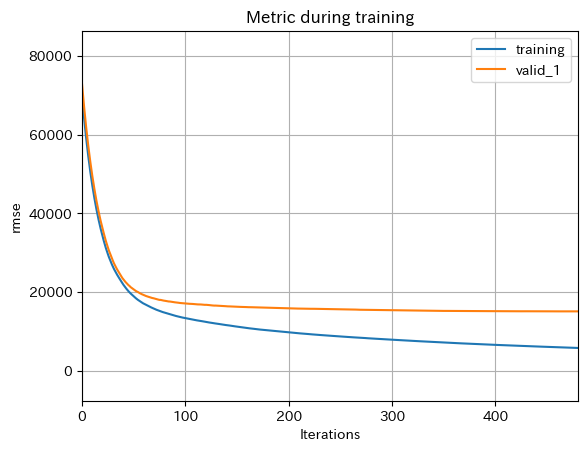

,importance
面積,4.425184e+14
L,3.940565e+14
平均地価,1.979675e+14
最寄り駅,9.500021e+13
築年数,5.805780e+13
...,...
庭,7.488594e+09
ペアガラス,7.196481e+09
クッションフロア,1.908112e+09
駐車場空無,1.178453e+09


In [192]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [193]:
df_importance[:20]

,importance
面積,4.425184e+14
L,3.940565e+14
平均地価,1.979675e+14
最寄り駅,9.500021e+13
築年数,5.805780e+13
所在地,3.643084e+13
一部屋あたりの面積,2.438393e+13
全体の階数,1.650981e+13
契約期間,1.395383e+13
洗面台独立,1.383553e+13


buildings(「鉄」という文字が含まれるか否か)よりもbuilding(きっちりカテゴリ化)の方が精度が悪くなる！？

buildingsとbuildingの両方入力してみる！

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
building = pd.read_csv('../data/handmade_data/building.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], 
                    building, buildings,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    kitchen_points, equipments, bath_toilet_points, broadcasts, parkings], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_building, test_buildings,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                     test_kitchen_points, test_equipments, test_bath_toilet_points, test_broadcasts, test_parkings], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','カテゴリ建物構造','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    'ガスコンロ', 'コンロ2口', 'システムキッチン', '給湯', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',
                    'エアコン付','シューズボックス','バルコニー','フローリング','室内洗濯機置場',
                    '敷地内ごみ置き場','エレベーター','公営水道','水道その他','下水','汲み取り','都市ガス','プロパンガス','タイル張',
                    'ウォークインクローゼット','2面採光','3面採光','24時間換気システム','ペアガラス','庭','クッションフロア','床暖房','ロフト',
                    '出窓','トランクルーム','オール電化',
                    '専用バス','バス・トイレ別','シャワー','専用トイレ','浴室乾燥機','温水洗浄便座',
                    '洗面台独立','脱衣所','追焚機能',
                    'インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー',
                    '高速インターネット','インターネット使用料無料',
                    '駐車場空有','駐車場空無','駐車場無','駐車場近隣',
                    '駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有'
                    ]

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 77
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.7	valid_1's rmse: 50156.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[20]	training's rmse: 34514.4	valid_1's rmse: 37763.5
[30]	training's rmse: 26076.4	valid_1's rmse: 30928.6
[40]	training's rmse: 21071.3	valid_1's rmse: 27129.8
[50]	training's rmse: 17797.1	valid_1's rmse: 24766.1
[60]	training's rmse: 15836.9	valid_1's rmse: 23333.5
[70]	training's rmse: 14392.7	valid_1's rmse: 22243.2
[80]	training's rmse: 13374.5	valid_1's rmse: 21539.9
[90]	training's rmse: 12599.1	valid_1's rmse: 21005
[100]	training's rmse: 11970.2	valid_1's rmse: 20578.4
[110]	training's rmse: 11398.6	valid_1's rmse: 20210.5
[120]	training's rmse: 10887.2	valid_1's rmse: 19854.5
[130]	training's rmse: 10470.2	valid_1's rmse: 19570.2
[140]	training's rmse: 10118.5	valid_1's rmse: 19346.6
[150]	training's rmse: 9773.13	valid_1's rmse: 19142.4
[160]	training's rmse: 9465.9	valid_1's rmse: 18958.7
[170]	training's rmse: 9167.68	valid_1's rmse: 18776.9
[180]	training's rmse: 8914.56	valid_1's rmse: 18612.6
[190]	training's rmse: 8695.55	valid_1's rmse: 18494.2
[200]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[20]	training's rmse: 34867.3	valid_1's rmse: 35872.3
[30]	training's rmse: 26653.5	valid_1's rmse: 28214.2
[40]	training's rmse: 21873.5	valid_1's rmse: 24023.1
[50]	training's rmse: 18932.1	valid_1's rmse: 21393.6
[60]	training's rmse: 17115.1	valid_1's rmse: 19935.1
[70]	training's rmse: 15768.3	valid_1's rmse: 19083.6
[80]	training's rmse: 14737.9	valid_1's rmse: 18497.5
[90]	training's rmse: 13919.2	valid_1's rmse: 18213.3
[100]	training's rmse: 13256.9	valid_1's rmse: 18112.2
[110]	training's rmse: 12732.5	valid_1's rmse: 18022.2
[120]	training's rmse: 12224.8	valid_1's rmse: 17955.6
[130]	training's rmse: 11773.9	valid_1's rmse: 17864.6
[140]	training's rmse: 11345.5	valid_1's rmse: 17826
[150]	training's rmse: 10973.8	valid_1's rmse: 17839.1
Early stopping, best iteration is:
[143]	training's rmse: 11234.5	valid_1's rmse: 17790.3
Start training...


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 77
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48905.3	valid_1's rmse: 48944.7
[20]	training's rmse: 35041.8	valid_1's rmse: 34777.7
[30]	training's rmse: 26743.7	valid_1's rmse: 27007
[40]	training's rmse: 21952.9	valid_1's rmse: 22777.6
[50]	training's rmse: 18896.1	valid_1's rmse: 20264.5
[60]	training's rmse: 16999.9	valid_1's rmse: 18985.7
[70]	training's rmse: 15679.1	valid_1's rmse: 18218.1
[80]	training's rmse: 14683.8	valid_1's rmse: 17759
[90]	training's rmse: 13890.5	valid_1's rmse: 17419.6
[100]	training's rmse: 13234.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 77
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49044.5	valid_1's rmse: 48028.5
[20]	training's rmse: 34714.8	valid_1's rmse: 35706.2
[30]	training's rmse: 26281.5	valid_1's rmse: 28844
[40]	training's rmse: 21325	valid_1's rmse: 25198.8
[50]	training's rmse: 18268.7	valid_1's rmse: 23293.7
[60]	training's rmse: 16412.3	valid_1's rmse: 22300
[70]	training's rmse: 15105	valid_1's rmse: 21822.7
[80]	training's rmse: 14150.7	valid_1's rmse: 21460.7
[90]	training's rmse: 13424.4	valid_1's rmse: 21193.5
[100]	training's rmse: 12808.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[10]	training's rmse: 48746.2	valid_1's rmse: 51230.9
[20]	training's rmse: 35081.7	valid_1's rmse: 37034.9
[30]	training's rmse: 26966.6	valid_1's rmse: 28494
[40]	training's rmse: 22285.8	valid_1's rmse: 23579.1
[50]	training's rmse: 19151.9	valid_1's rmse: 20862.7
[60]	training's rmse: 17173	valid_1's rmse: 19336.8
[70]	training's rmse: 15871.8	valid_1's rmse: 18450.2
[80]	training's rmse: 14860.8	valid_1's rmse: 17843.2
[90]	training's rmse: 14068.5	valid_1's rmse: 17446.5
[100]	training's rmse: 13440.7	valid_1's rmse: 17147.9
[110]	training's rmse: 12934.8	valid_1's rmse: 16950.2
[120]	training's rmse: 12492	valid_1's rmse: 16763.9
[130]	training's rmse: 12041	valid_1's rmse: 16580.7
[140]	training's rmse: 11643.9	valid_1's rmse: 16425.5
[150]	training's rmse: 11269	valid_1's rmse: 16271.6
[160]	training's rmse: 10902.4	valid_1's rmse: 16199.4
[170]	training's rmse: 10587.5	valid_1's rmse: 16121.2
[180]	training's rmse: 10303.3	valid_1's rmse: 16041.4
[190]	training's rmse: 10045.

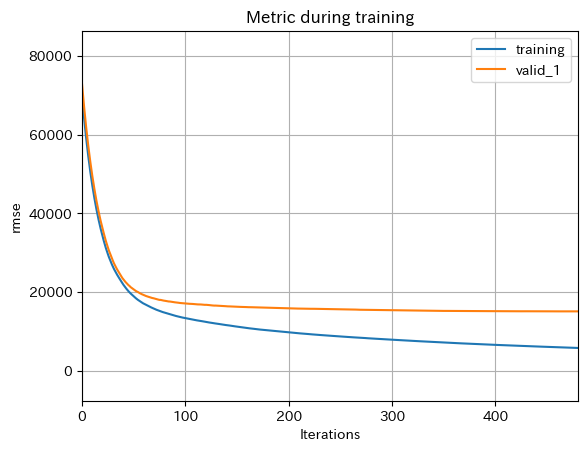

,importance
面積,4.425184e+14
L,3.940565e+14
平均地価,1.979675e+14
最寄り駅,9.500021e+13
築年数,5.805780e+13
...,...
庭,7.488594e+09
ペアガラス,7.196481e+09
クッションフロア,1.908112e+09
駐車場空無,1.178453e+09


In [195]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

buildingを抜き、buidingsだけにしてみる！

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
building = pd.read_csv('../data/handmade_data/building.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], 
                    buildings,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    kitchen_points, equipments, bath_toilet_points, broadcasts, parkings], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_buildings,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                     test_kitchen_points, test_equipments, test_bath_toilet_points, test_broadcasts, test_parkings], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    'ガスコンロ', 'コンロ2口', 'システムキッチン', '給湯', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',
                    'エアコン付','シューズボックス','バルコニー','フローリング','室内洗濯機置場',
                    '敷地内ごみ置き場','エレベーター','公営水道','水道その他','下水','汲み取り','都市ガス','プロパンガス','タイル張',
                    'ウォークインクローゼット','2面採光','3面採光','24時間換気システム','ペアガラス','庭','クッションフロア','床暖房','ロフト',
                    '出窓','トランクルーム','オール電化',
                    '専用バス','バス・トイレ別','シャワー','専用トイレ','浴室乾燥機','温水洗浄便座',
                    '洗面台独立','脱衣所','追焚機能',
                    'インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー',
                    '高速インターネット','インターネット使用料無料',
                    '駐車場空有','駐車場空無','駐車場無','駐車場近隣',
                    '駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有'
                    ]

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2860
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 76
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48810.3	valid_1's rmse: 50148.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '公営水道', '出窓',

[20]	training's rmse: 34504.5	valid_1's rmse: 37697
[30]	training's rmse: 26051.4	valid_1's rmse: 30791.8
[40]	training's rmse: 21048.7	valid_1's rmse: 26985.5
[50]	training's rmse: 17823	valid_1's rmse: 24657.9
[60]	training's rmse: 15809.5	valid_1's rmse: 23218.5
[70]	training's rmse: 14382.3	valid_1's rmse: 22150
[80]	training's rmse: 13400.9	valid_1's rmse: 21455.8
[90]	training's rmse: 12614.5	valid_1's rmse: 20959.9
[100]	training's rmse: 11957.1	valid_1's rmse: 20524.5
[110]	training's rmse: 11419.3	valid_1's rmse: 20186.5
[120]	training's rmse: 10895.8	valid_1's rmse: 19808.9
[130]	training's rmse: 10504.7	valid_1's rmse: 19540.5
[140]	training's rmse: 10129.9	valid_1's rmse: 19337.7
[150]	training's rmse: 9804.66	valid_1's rmse: 19179.9
[160]	training's rmse: 9483.94	valid_1's rmse: 18978.6
[170]	training's rmse: 9206.64	valid_1's rmse: 18788.7
[180]	training's rmse: 8939.34	valid_1's rmse: 18628.5
[190]	training's rmse: 8693.38	valid_1's rmse: 18442.4
[200]	training's rmse: 8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '公営水道', '出窓',

[20]	training's rmse: 34935.7	valid_1's rmse: 35933.7
[30]	training's rmse: 26705.6	valid_1's rmse: 28331.5
[40]	training's rmse: 21982.1	valid_1's rmse: 24151.7
[50]	training's rmse: 18996.7	valid_1's rmse: 21369.3
[60]	training's rmse: 17156.5	valid_1's rmse: 20014.4
[70]	training's rmse: 15844.1	valid_1's rmse: 19071.9
[80]	training's rmse: 14816	valid_1's rmse: 18437.3
[90]	training's rmse: 13979.8	valid_1's rmse: 18272.5
[100]	training's rmse: 13300.1	valid_1's rmse: 18086.3
[110]	training's rmse: 12777.3	valid_1's rmse: 17997.7
[120]	training's rmse: 12245	valid_1's rmse: 17876.6
[130]	training's rmse: 11798.2	valid_1's rmse: 17818.3
[140]	training's rmse: 11402.7	valid_1's rmse: 17811.9
Early stopping, best iteration is:
[135]	training's rmse: 11601.3	valid_1's rmse: 17778.1
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '公営水道', '出窓',

[20]	training's rmse: 35083.1	valid_1's rmse: 34874.2
[30]	training's rmse: 26830.8	valid_1's rmse: 27020.8
[40]	training's rmse: 22053.7	valid_1's rmse: 22849
[50]	training's rmse: 19016.6	valid_1's rmse: 20380.3
[60]	training's rmse: 17044.9	valid_1's rmse: 19089.1
[70]	training's rmse: 15734.1	valid_1's rmse: 18343.6
[80]	training's rmse: 14711.1	valid_1's rmse: 17917.7
[90]	training's rmse: 13907.5	valid_1's rmse: 17654.8
[100]	training's rmse: 13283.9	valid_1's rmse: 17509.6
[110]	training's rmse: 12722.9	valid_1's rmse: 17376.4
[120]	training's rmse: 12237.1	valid_1's rmse: 17323.9
[130]	training's rmse: 11750	valid_1's rmse: 17228.7
[140]	training's rmse: 11366.7	valid_1's rmse: 17166
[150]	training's rmse: 10994.8	valid_1's rmse: 17145.8
[160]	training's rmse: 10665	valid_1's rmse: 17109.5
[170]	training's rmse: 10356.6	valid_1's rmse: 17066.3
[180]	training's rmse: 10060	valid_1's rmse: 17032.5
[190]	training's rmse: 9781.71	valid_1's rmse: 16998
[200]	training's rmse: 9521.45

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '公営水道', '出窓',

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2858
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 76
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49060	valid_1's rmse: 48045.8
[20]	training's rmse: 34761	valid_1's rmse: 35735.9
[30]	training's rmse: 26201	valid_1's rmse: 28844.4
[40]	training's rmse: 21352.9	valid_1's rmse: 25290.7
[50]	training's rmse: 18264.9	valid_1's rmse: 23425.1
[60]	training's rmse: 16360	valid_1's rmse: 22545.1
[70]	training's rmse: 15018.6	valid_1's rmse: 22057
[80]	training's rmse: 14102.1	valid_1's rmse: 21666.3
[90]	training's rmse: 13380.5	valid_1's rmse: 21408.7
[100]	training's rmse: 12775.7	valid_1's rmse: 21

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '公営水道', '出窓',

[10]	training's rmse: 48751	valid_1's rmse: 51230.4
[20]	training's rmse: 35067.1	valid_1's rmse: 37043.1
[30]	training's rmse: 26924.6	valid_1's rmse: 28497.6
[40]	training's rmse: 22164.7	valid_1's rmse: 23590.2
[50]	training's rmse: 19088.4	valid_1's rmse: 20794.4
[60]	training's rmse: 17087.3	valid_1's rmse: 19287.6
[70]	training's rmse: 15751.1	valid_1's rmse: 18384.4
[80]	training's rmse: 14769.2	valid_1's rmse: 17796.3
[90]	training's rmse: 14038	valid_1's rmse: 17379.5
[100]	training's rmse: 13415.1	valid_1's rmse: 17098.5
[110]	training's rmse: 12913.1	valid_1's rmse: 16906.9
[120]	training's rmse: 12460.1	valid_1's rmse: 16735.5
[130]	training's rmse: 12040.3	valid_1's rmse: 16568.1
[140]	training's rmse: 11629.3	valid_1's rmse: 16461.9
[150]	training's rmse: 11272.8	valid_1's rmse: 16319.7
[160]	training's rmse: 10921.8	valid_1's rmse: 16213.4
[170]	training's rmse: 10619.7	valid_1's rmse: 16097.9
[180]	training's rmse: 10341.1	valid_1's rmse: 16019.4
[190]	training's rmse: 

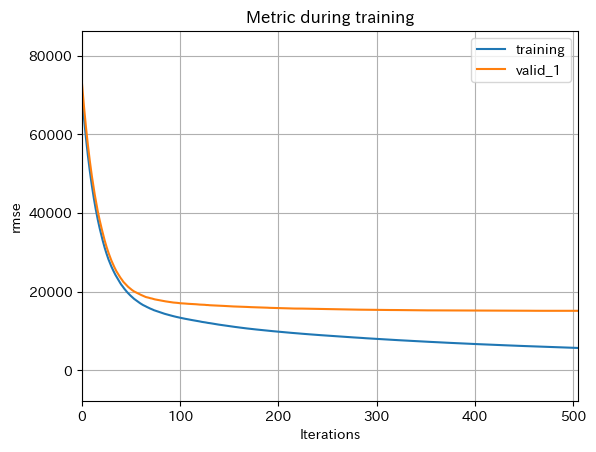

,importance
面積,4.418457e+14
L,3.945508e+14
平均地価,1.998917e+14
最寄り駅,9.416939e+13
築年数,5.886148e+13
...,...
電気コンロ,1.194761e+10
庭,1.158849e+10
クッションフロア,3.464700e+09
駐車場空無,1.669774e+09


In [197]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

# 結果、buildingsとbuildingの両方を入れておくのが1番スコアが良い！